<a href="https://colab.research.google.com/github/DinurakshanRavichandran/Visio-Glance/blob/FINAL-MODEL-NLP/unified_eye_disease_detection_corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unified Eye Disease Detection Model
This notebook implements a machine learning pipeline to predict one of six eye diseases based on symptom datasets.

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


01) Concatenating the 6 datasets.

In [32]:
import pandas as pd

# Load all datasets (assuming they are stored as CSV files in a folder)
datasets = {
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/preprocessed_glaucoma_dataset.csv" : "Glaucoma",
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/Preprocessed_Cataract_Dataset.csv" : "Cataract",
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/Preprocessed_Diabetic_Retinopathy_Dataset.csv" : "Diabetic Retinopathy",
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/Preprocessed_CNV_Detection_Dataset.csv" : "CNV",
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/Preprocessed_DME_Dataset.csv" : "DME",
              "/content/drive/MyDrive/PROJECT 29/FINAL MODEL/Preprocessed_Drusen_Dataset.csv" : "Drusen"
}

# Load and label each dataset
dataframes = []
for file, disease in datasets.items():
    df = pd.read_csv(file)  # Load dataset
    df["Disease_Label"] = disease  # Add disease label
    dataframes.append(df)

# Concatenate all datasets
merged_df = pd.concat(dataframes, ignore_index=True)

# Fill missing values with zero
merged_df.fillna(0, inplace=True)

# Save the merged dataset
merged_df.to_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv", index=False)

# Display dataset shape and preview
print(f"Final dataset shape: {merged_df.shape}")
print(merged_df.head())


Final dataset shape: (73624, 112)
   Age  Intraocular Pressure (IOP)  Cup-to-Disc Ratio (CDR)  Pachymetry  \
0   69                       19.46                     0.42      541.51   
1   69                       18.39                     0.72      552.77   
2   67                       23.65                     0.72      573.65   
3   23                       18.04                     0.61      590.67   
4   21                       15.87                     0.30      588.41   

   Diagnosis  Visual Symptom_vomiting  Visual Symptom_nausea  \
0          1                      0.0                    1.0   
1          1                      0.0                    0.0   
2          1                      0.0                    0.0   
3          1                      0.0                    1.0   
4          1                      0.0                    0.0   

   Visual Symptom_eye pain  Visual Symptom_vision loss  \
0                      1.0                         0.0   
1             

02) Multi-Class Classification (Detect Specific Disease)

In [33]:
from sklearn.preprocessing import LabelEncoder

# Encode Disease_Label into numerical values (0-5)
label_encoder = LabelEncoder()
merged_df["Diagnosis"] = label_encoder.fit_transform(merged_df["Disease_Label"])

# Drop the original text label column
merged_df.drop(columns=["Disease_Label"], inplace=True)

# Save the updated dataset
merged_df.to_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_multi_class_classification.csv", index=False)

# Print class mapping
print("Class Mapping:", dict(enumerate(label_encoder.classes_)))
print("Multi-class classification dataset prepared!")


Class Mapping: {0: 'CNV', 1: 'Cataract', 2: 'DME', 3: 'Diabetic Retinopathy', 4: 'Drusen', 5: 'Glaucoma'}
Multi-class classification dataset prepared!


Step 01: Load and Prepare the Dataset.

In [35]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the merged dataset
df = pd.read_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv")

# Encode the Disease_Label for multi-class classification
label_encoder = LabelEncoder()
df["Diagnosis"] = label_encoder.fit_transform(df["Disease_Label"])

# Drop the original text label column
df.drop(columns=["Disease_Label"], inplace=True)

# Split features and target
X = df.drop(columns=["Diagnosis"])  # Features
y = df["Diagnosis"]  # Target variable

# Train-test split (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Dataset prepared! Shape:", df.shape)
print("Class Mapping:", dict(enumerate(label_encoder.classes_)))


<ipython-input-35-5c3ffac6d96c>:8: DtypeWarning: Columns (18,19,20,21,94,95,96,97,98,99,100,104,105,106,107,108,109,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv")


Dataset prepared! Shape: (73624, 111)
Class Mapping: {0: 'CNV', 1: 'Cataract', 2: 'DME', 3: 'Diabetic Retinopathy', 4: 'Drusen', 5: 'Glaucoma'}


 Converting Categorical Columns to Numeric Format.

In [38]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv")

# Identify categorical columns (non-numeric)
categorical_cols = df.select_dtypes(include=["object"]).columns

# Apply one-hot encoding
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)  # Drop first to avoid multicollinearity

# Save the updated dataset
df.to_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset_encoded.csv", index=False)

print("Categorical columns converted! Shape:", df.shape)


<ipython-input-38-0013f7d94314>:4: DtypeWarning: Columns (18,19,20,21,94,95,96,97,98,99,100,104,105,106,107,108,109,110,111) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset.csv")


Categorical columns converted! Shape: (73624, 173)


Step 02: Loading the Encoded Dataset and Preparing for Training.

In [40]:
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load the encoded dataset
df = pd.read_csv("/content/drive/MyDrive/PROJECT 29/FINAL MODEL/merged_dataset_encoded.csv")

# Separate features and target variable
X = df.drop(columns=["Diagnosis"])  # Features
y = df["Diagnosis"]  # Target variable

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Data split completed! Train shape:", X_train.shape, "Test shape:", X_test.shape)


Data split completed! Train shape: (58899, 172) Test shape: (14725, 172)


Step 03: Training an XGBoost Model.

In [41]:
# Initialize XGBoost model for multi-class classification
model = XGBClassifier(
    objective="multi:softmax",  # Multi-class classification
    num_class=len(y.unique()),  # Number of disease categories
    eval_metric="mlogloss",
    use_label_encoder=False,
    learning_rate=0.05,
    n_estimators=500,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

print("XGBoost Model Trained Successfully!")


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:10:03] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Model Trained Successfully!


Step 04: Evaluation of the Model.

In [44]:
# Make predictions
y_pred = model.predict(X_test)

# Evaluate model performance
accuracy = accuracy_score(y_test, y_pred) * 100 #convert to percentage.
print(f"Model Accuracy: {accuracy:.2f}%") #display with 2 decimal places.
print("Classification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 82.51%
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.89      0.84      7442
           1       0.87      0.76      0.81      7283

    accuracy                           0.83     14725
   macro avg       0.83      0.82      0.82     14725
weighted avg       0.83      0.83      0.82     14725



Step 05: Feature Importance Visualization

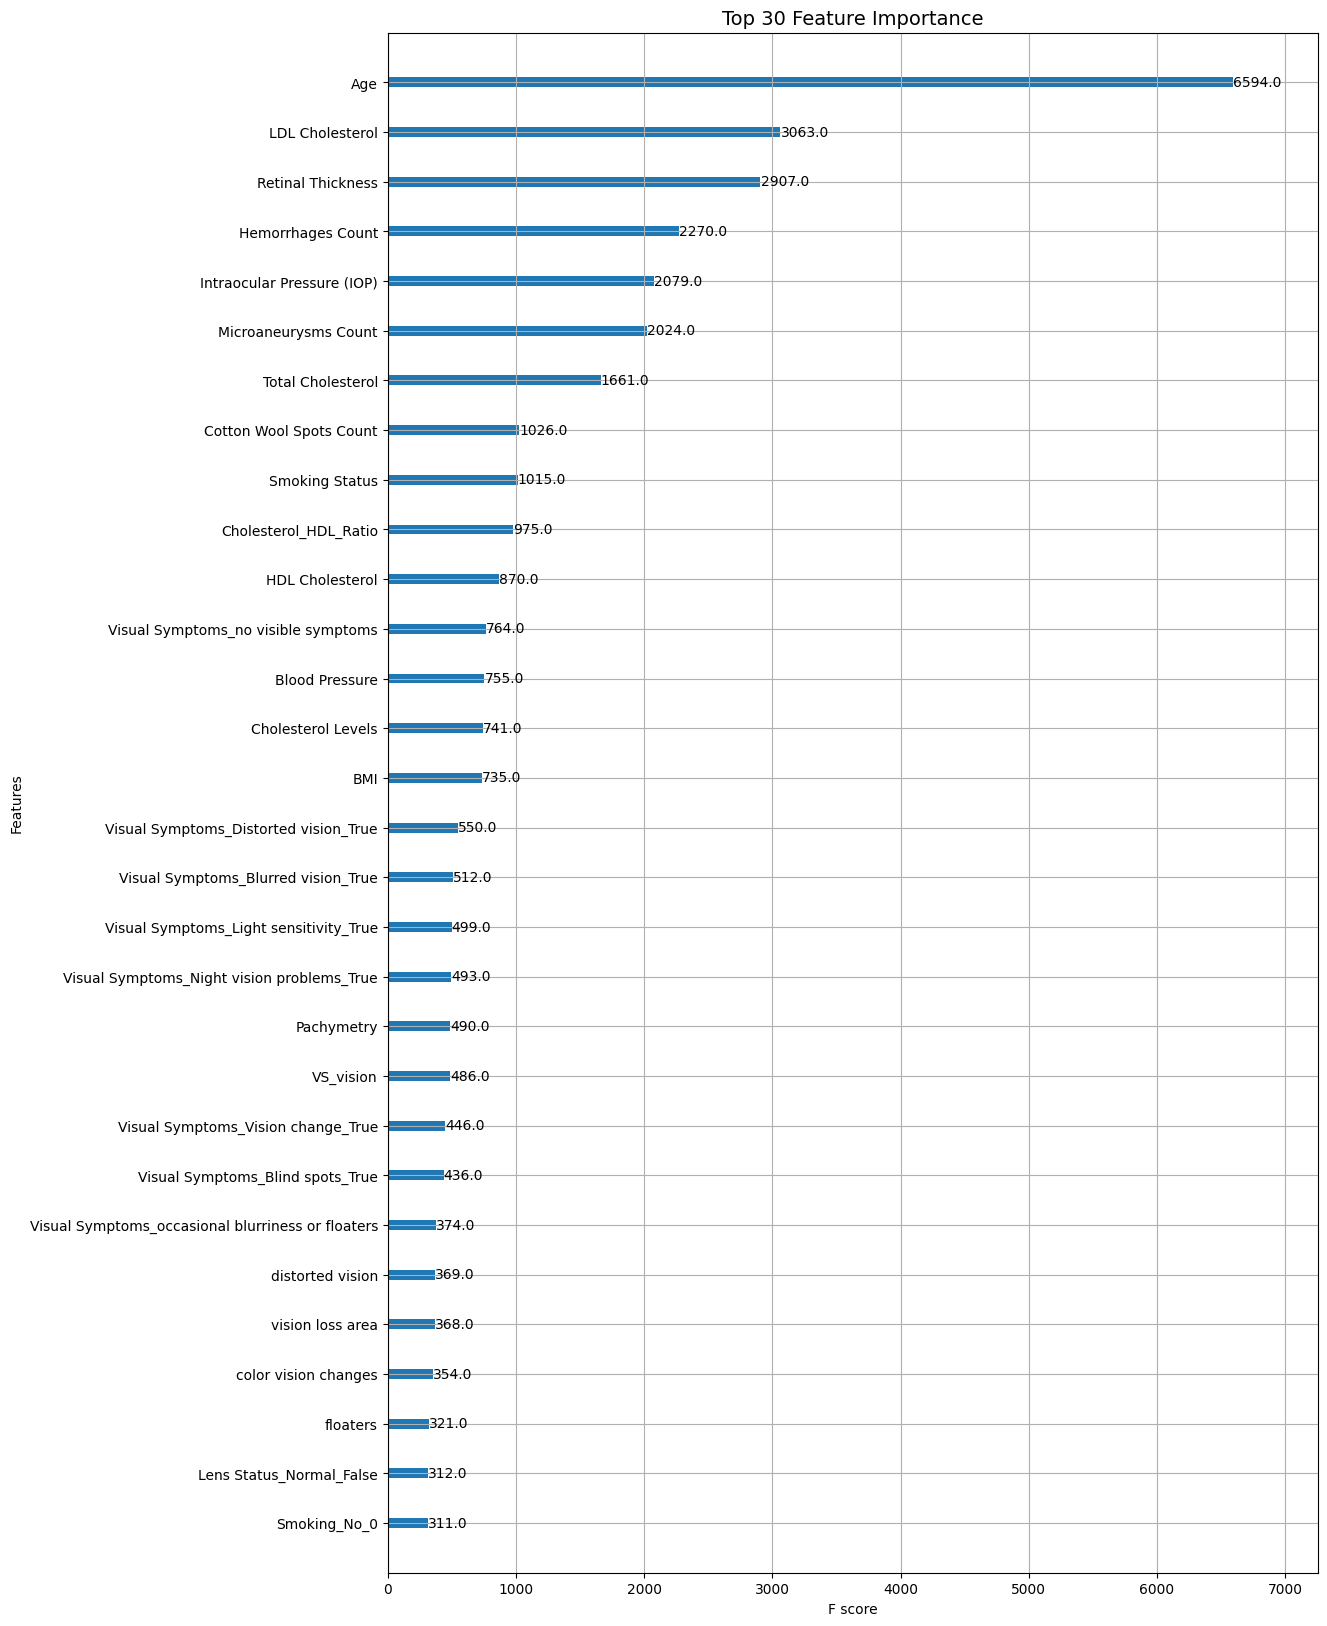

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from xgboost import plot_importance

# Set figure size and sort features by importance
fig, ax = plt.subplots(figsize=(12, 20))  # Increased height for better readability
plot_importance(model, ax=ax, max_num_features=30)  # Show only the top 30 features
plt.title("Top 30 Feature Importance", fontsize=14)
plt.show()